In [1]:
%matplotlib inline
%pylab inline
figsize(30,30)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import orekit
vm = orekit.initVM()

In [3]:
from orekit.pyhelpers import setup_orekit_curdir
setup_orekit_curdir()

In [4]:
from org.orekit.frames import FramesFactory, TopocentricFrame
from org.orekit.bodies import OneAxisEllipsoid, GeodeticPoint
from org.orekit.propagation.analytical.tle import TLE, TLEPropagator
from org.orekit.utils import IERSConventions, Constants
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.time import AbsoluteDate, TimeScalesFactory

In [5]:
from math import *
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from WhenIsTheISSAboveMe import getISSTle

In [7]:
tle = getISSTle()
tle

<TLE: 1 25544U 98067A   20239.33761196  .00000797  00000-0  22467-4 0  9990

2 25544  51.6464   1.3022 0001695  60.5469 358.5199 15.49187877242899
>

In [32]:
ITRF = FramesFactory.getITRF(IERSConventions.IERS_2010, True)
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                         Constants.WGS84_EARTH_FLATTENING, ITRF)

In [33]:
#definition of the station
longitude = radians(7.75)
latitude = radians(48.58)
altitude = 142.0
station = GeodeticPoint(latitude, longitude, altitude)
lolo = GeodeticPoint(0.0, 0.0, 0.0)
stationFrame = TopocentricFrame(earth, station, "Strasbourg")
loloFrame = TopocentricFrame(earth, lolo, "Lolo Point")

In [34]:
stationFrame.getPoint()

<GeodeticPoint: {lat: 48.58 deg, lon: 7.75 deg, alt: 142}>

In [54]:
inertialFrame = FramesFactory.getEME2000()

In [55]:
propagator = TLEPropagator.selectExtrapolator(tle)

In [56]:
propagator.getFrame()

<Frame: TEME>

In [57]:
from org.orekit.propagation.analytical import KeplerianPropagator
from org.orekit.propagation.sampling import OrekitFixedStepHandler
from org.orekit.propagation.events.handlers import StopOnDecreasing, RecordAndContinue, ContinueOnEvent, StopOnIncreasing
from org.orekit.propagation import SpacecraftState
from org.orekit.propagation.events import ElevationDetector, EventsLogger
from org.orekit.orbits import KeplerianOrbit, PositionAngle

In [58]:
n = tle.getMeanMotion()
a = (Constants.WGS84_EARTH_MU/(n**2))**(1/3)
e = tle.getE()
i = tle.getI()
omega = tle.getPerigeeArgument()   # perigee argument
raan = tle.getRaan()  # right ascension of ascending node
m = tle.getMeanAnomaly()   # True anomaly
lv = m + (2*e-0.25*e**3)*sin(m) + 1.25*e**2*sin(2*m) + 13*e**3*sin(3*m)/12

In [59]:
degrees(m)
degrees(lv)

298.946701952468

In [60]:
extrapDate = tle.getDate()
ISSOrbit = KeplerianOrbit(a, e, i, omega, raan, lv,
                              PositionAngle.TRUE,
                              inertialFrame, extrapDate, Constants.WGS84_EARTH_MU)
ISSpropagator = KeplerianPropagator(ISSOrbit)

In [61]:
extrapDate

<AbsoluteDate: 2020-08-26T03:11:20.000>

In [62]:
minEle = radians(5.0)
elevation_detector = ElevationDetector(60.0, 0.001, stationFrame).withConstantElevation(minEle).withHandler(RecordAndContinue())

In [63]:
minEle

0.08726646259971647

In [64]:
logger = EventsLogger()
logged_detector = logger.monitorDetector(elevation_detector)
ISSpropagator.addEventDetector(logged_detector)

In [65]:
propagator.addEventDetector(logged_detector)

In [66]:
state = propagator.propagate(extrapDate, extrapDate.shiftedBy(1600.0))
state.getDate()

<AbsoluteDate: 2020-08-26T03:38:00.000>

In [67]:
events = logger.getLoggedEvents()
events.size()

2

In [68]:
events.get(1).getState().getPVCoordinates().getDate()

<AbsoluteDate: 2020-08-26T03:29:39.243>

In [69]:
events.get(1).getState().getFrame()

<Frame: TEME>

In [73]:
maxPos = events.get(1).getState().getPVCoordinates().getPosition()
eleMax = stationFrame.getElevation(maxPos, inertialFrame, state.getDate())
degrees(eleMax)

6.571590263153289

In [71]:
events.get(1).getState().getDate()

<AbsoluteDate: 2020-08-26T03:29:39.243>

In [236]:
state = ISSpropagator.propagate(extrapDate, extrapDate.shiftedBy(3600.0 * 24))

In [237]:
state.getDate()

<AbsoluteDate: 2020-08-26T20:02:32.022>

In [239]:
posMaxInStationFrame = state.getPVCoordinates().getPosition()
posMaxInStationFrame
eleMax = stationFrame.getElevation(posMaxInStationFrame, inertialFrame, state.getDate())
degrees(eleMax)

-45.043834358935854

In [42]:
X=[]
Xbis=[]
Y=[]
Ybis=[]
pos=[]
Date=[]
Dist=[]
Latitude=[]
Longitude=[]
Ele =[]

extrapDate = AbsoluteDate(2020, 8, 20, 12, 50, 16.34, TimeScalesFactory.getUTC())
finalDate = extrapDate.shiftedBy(60.0*60*24) #seconds

In [43]:
def isVisible(x, y):
    if abs(x)<=8000 and abs(y)<=8000:
        return True
    return False

In [44]:
extrapDate = AbsoluteDate(2020, 8, 20, 12, 50, 16.34, TimeScalesFactory.getUTC())
finalDate = extrapDate.shiftedBy(60.0*60*24*2+60.0*60*4) #seconds

currentX = 8001
currentY = 8001
currentAz = 0
CurrentDist = 0
k=0
currentEle = 0
while (extrapDate.compareTo(finalDate) <= 0.0):  
# while (not isVisible(currentX, currentY) and k<300):  
    pv = propagator.getPVCoordinates(extrapDate, inertialFrame)
    pos_tmp = pv.getPosition()
    pos.append((pos_tmp.getX(),pos_tmp.getY(),pos_tmp.getZ()))
    
    currentGeodeticPoint = earth.transform(earth.projectToGround(pos_tmp, extrapDate, inertialFrame),
                                           inertialFrame, extrapDate)
    
    
    currentPosInertialFrame = stationFrame.getPVCoordinates(extrapDate, inertialFrame)
    currentDist = Vector3D.distance(pos_tmp, currentPosInertialFrame.getPosition())
    currentAz = stationFrame.getAzimuth(pos_tmp, inertialFrame, extrapDate)
    currentEle = stationFrame.getElevation(pos_tmp, inertialFrame, extrapDate)
    currentX = sin(currentAz)*currentDist*cos(currentEle)
    currentY = cos(currentAz)*currentDist*cos(currentEle)
    
    Ele.append(currentEle)
    X.append(currentX)
    Y.append(currentY)
    Dist.append(currentDist)
    Latitude.append(currentGeodeticPoint.getLatitude())
    Longitude.append(currentGeodeticPoint.getLongitude())

    k+=1
    Date.append(extrapDate)
    #print extrapDate, pos_tmp, vel_tmp
    extrapDate = extrapDate.shiftedBy(20.0)

In [54]:
degrees(stationFrame.getElevation(pos_tmp, inertialFrame, extrapDate))

-59.34025146192853

In [53]:
degrees(currentEle)

-59.362204782563325

In [32]:
extrapDate = AbsoluteDate(2020, 8, 20, 12, 50, 16.34, TimeScalesFactory.getUTC())
finalDate = extrapDate.shiftedBy(60.0*60*24*2+60.0*60*4) #seconds

currentX = 8001
currentY = 8001
currentAz = 0
CurrentDist = 0
k=0
currentEle = 0
while (extrapDate.compareTo(finalDate) <= 0.0):  
# while (not isVisible(currentX, currentY) and k<300):  
    pv = propagator.getPVCoordinates(extrapDate, inertialFrame)
    pos_tmp = pv.getPosition()
    pos.append((pos_tmp.getX(),pos_tmp.getY(),pos_tmp.getZ()))
    
    currentGeodeticPoint = earth.transform(earth.projectToGround(pos_tmp, extrapDate, inertialFrame),
                                           inertialFrame, extrapDate)
    
    
    inertial2stationFrame = inertialFrame.getTransformTo(stationFrame, extrapDate)
    
    currentPosInStationFrame = inertial2stationFrame.transformPosition(pos_tmp)
    
#     currentPosInertialFrame = stationFrame.getPVCoordinates(extrapDate, inertialFrame)
#     currentDist = Vector3D.distance(pos_tmp, currentPosInertialFrame.getPosition())
#     currentAz = stationFrame.getAzimuth(pos_tmp, inertialFrame, extrapDate)
#     currentEle = stationFrame.getElevation(pos_tmp, inertialFrame, extrapDate)
#     currentX = sin(currentAz)*currentDist*cos(currentEle)
#     currentY = cos(currentAz)*currentDist*cos(currentEle)

    currentX = currentPosInStationFrame.getX()
    currentY = currentPosInStationFrame.getY()
    
#     Ele.append(currentEle)
#     Dist.append(currentDist)
    
    Latitude.append(currentGeodeticPoint.getLatitude())
    Longitude.append(currentGeodeticPoint.getLongitude())
    Xbis.append(currentX)
    Ybis.append(currentY)

    k+=1
    Date.append(extrapDate)
    #print extrapDate, pos_tmp, vel_tmp
    extrapDate = extrapDate.shiftedBy(20.0)

In [43]:
print(X[0])
print(Y[0])
print(k)
propagator.getInitialState()

-4196437.47935558
2405391.3166567534
9361


<SpacecraftState: SpacecraftState{orbit=Cartesian parameters: {P(-594136.556922841, 4374663.953231822, 5158254.016907514), V(-7017.359867044968, -2701.8651223134025, 1480.1651329231527)}, attitude=org.orekit.attitudes.Attitude@4963f88b, mass=1000.0, additional={}}>

In [31]:
print(Xbis[-1])
print(Ybis[-1])
print(k)

4458958.663246841
-3758689.708626182
9361


In [121]:
X = np.array(X)
Y = np.array(Y)
Xbis = np.array(Xbis)
Ybis = np.array(Ybis)
Latitude = np.array(Latitude)
Longitude = np.array(Longitude)

In [122]:
print(np.nanmin(np.abs(X)))
print(np.nanargmin(np.abs(X)))
print(X[np.nanargmin(np.abs(X))])

588.247803203537
1253
588.247803203537


In [123]:
print(np.nanmin(np.abs(Xbis)))
print(np.nanargmin(np.abs(Xbis)))
print(Xbis[np.nanargmin(np.abs(Xbis))])

588.247803204431
1253
588.247803204431


In [124]:
print(np.min(np.abs(Y)))
print(np.argmin(np.abs(Y)))
print(Y[np.argmin(np.abs(Y))])

184.50860087541403
2489
-184.50860087541403


In [125]:
print(np.min(np.abs(Ybis)))
print(np.argmin(np.abs(Ybis)))
print(Ybis[np.argmin(np.abs(Ybis))])

184.5086008743383
2489
-184.5086008743383


In [126]:
Y[3342]

14461.972923961277

In [127]:
print(np.nanmin(np.abs(Dist)))
print(np.nanargmin(np.abs(Dist)))
print(Dist[np.nanargmin(np.abs(Dist))])

429165.7803167019
3342
429165.7803167019


In [128]:
Dist[234]-Dist[235]

78295.02046424896

In [129]:
i = 0
bool = False
count = 0
Index = []
for i in range(len(X)):
#     print(abs(X[i]))
#     print(X[i])
    if (abs(X[i])<= 100000 and abs(Y[i]) <= 100000):
        bool = True
        count += 1
        Index.append(i)
print(bool)
print(count)
print(Index)

True
4
[3341, 3342, 7664, 8246]


In [130]:
Latitude = np.degrees(Latitude)
Longitude = np.degrees(Longitude)

<ipython-input-149-8b0b18595b93>:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m = Basemap(projection='cyl',


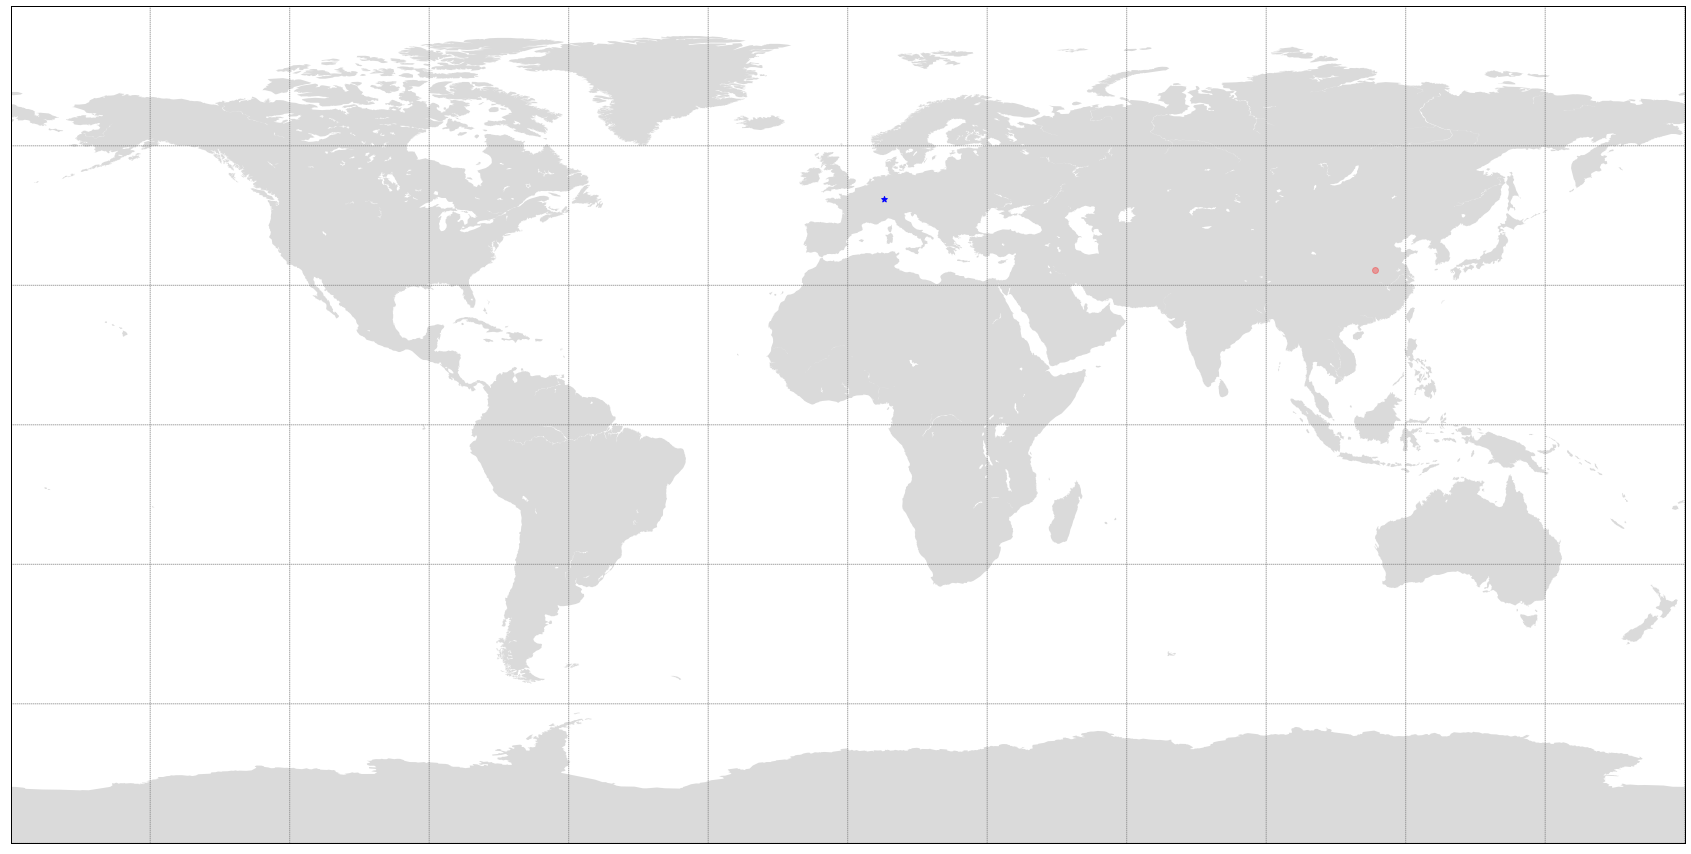

In [149]:
m = Basemap(projection='cyl',
            resolution='l',
            area_thresh=None)

m.drawmapboundary()     # fill_color='aqua')
m.fillcontinents(color='#dadada', lake_color='white')
m.drawmeridians(np.arange(-180, 180, 30), color='gray')
m.drawparallels(np.arange(-90, 90, 30), color='gray');

m.scatter(Longitude[3112], Latitude[3112], alpha=0.3, color='red', zorder=3, marker='o');
m.scatter(np.degrees(longitude), np.degrees(latitude), alpha=1, color='blue', zorder=3, marker='*');

<ipython-input-132-1d6661b14e20>:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m = Basemap(projection='cyl',


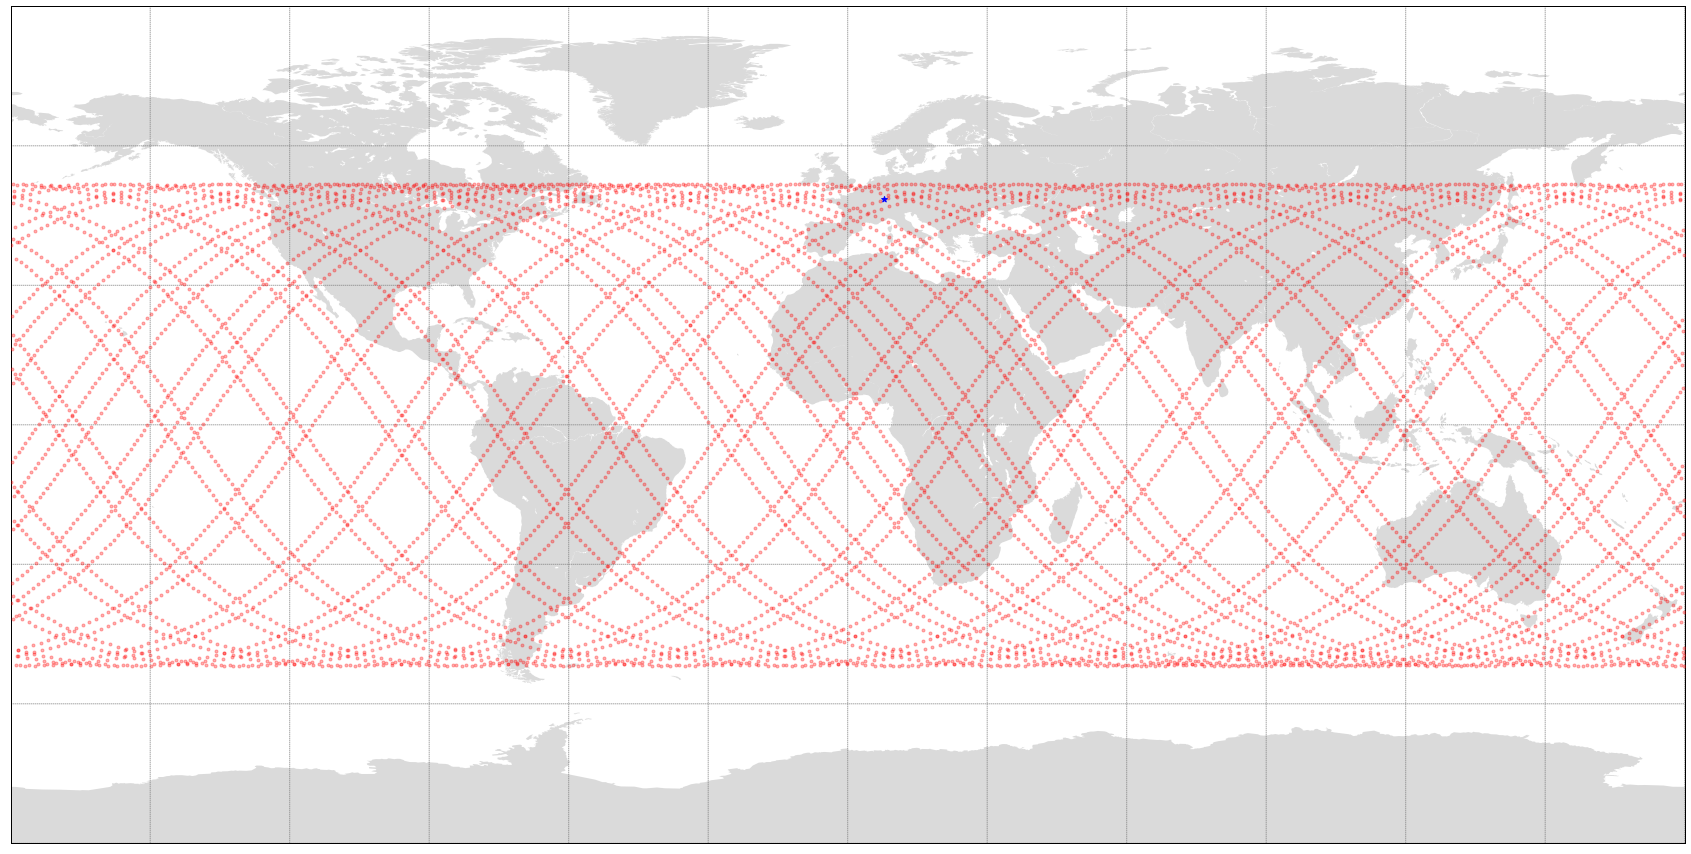

In [132]:
m = Basemap(projection='cyl',
            resolution='l',
            area_thresh=None)

m.drawmapboundary()     # fill_color='aqua')
m.fillcontinents(color='#dadada', lake_color='white')
m.drawmeridians(np.arange(-180, 180, 30), color='gray')
m.drawparallels(np.arange(-90, 90, 30), color='gray');

m.scatter(Longitude[len(Longitude)//2:], Latitude[len(Longitude)//2:], alpha=0.3, color='red', zorder=3, marker='.');
m.scatter(np.degrees(longitude), np.degrees(latitude), alpha=1, color='blue', zorder=3, marker='*');

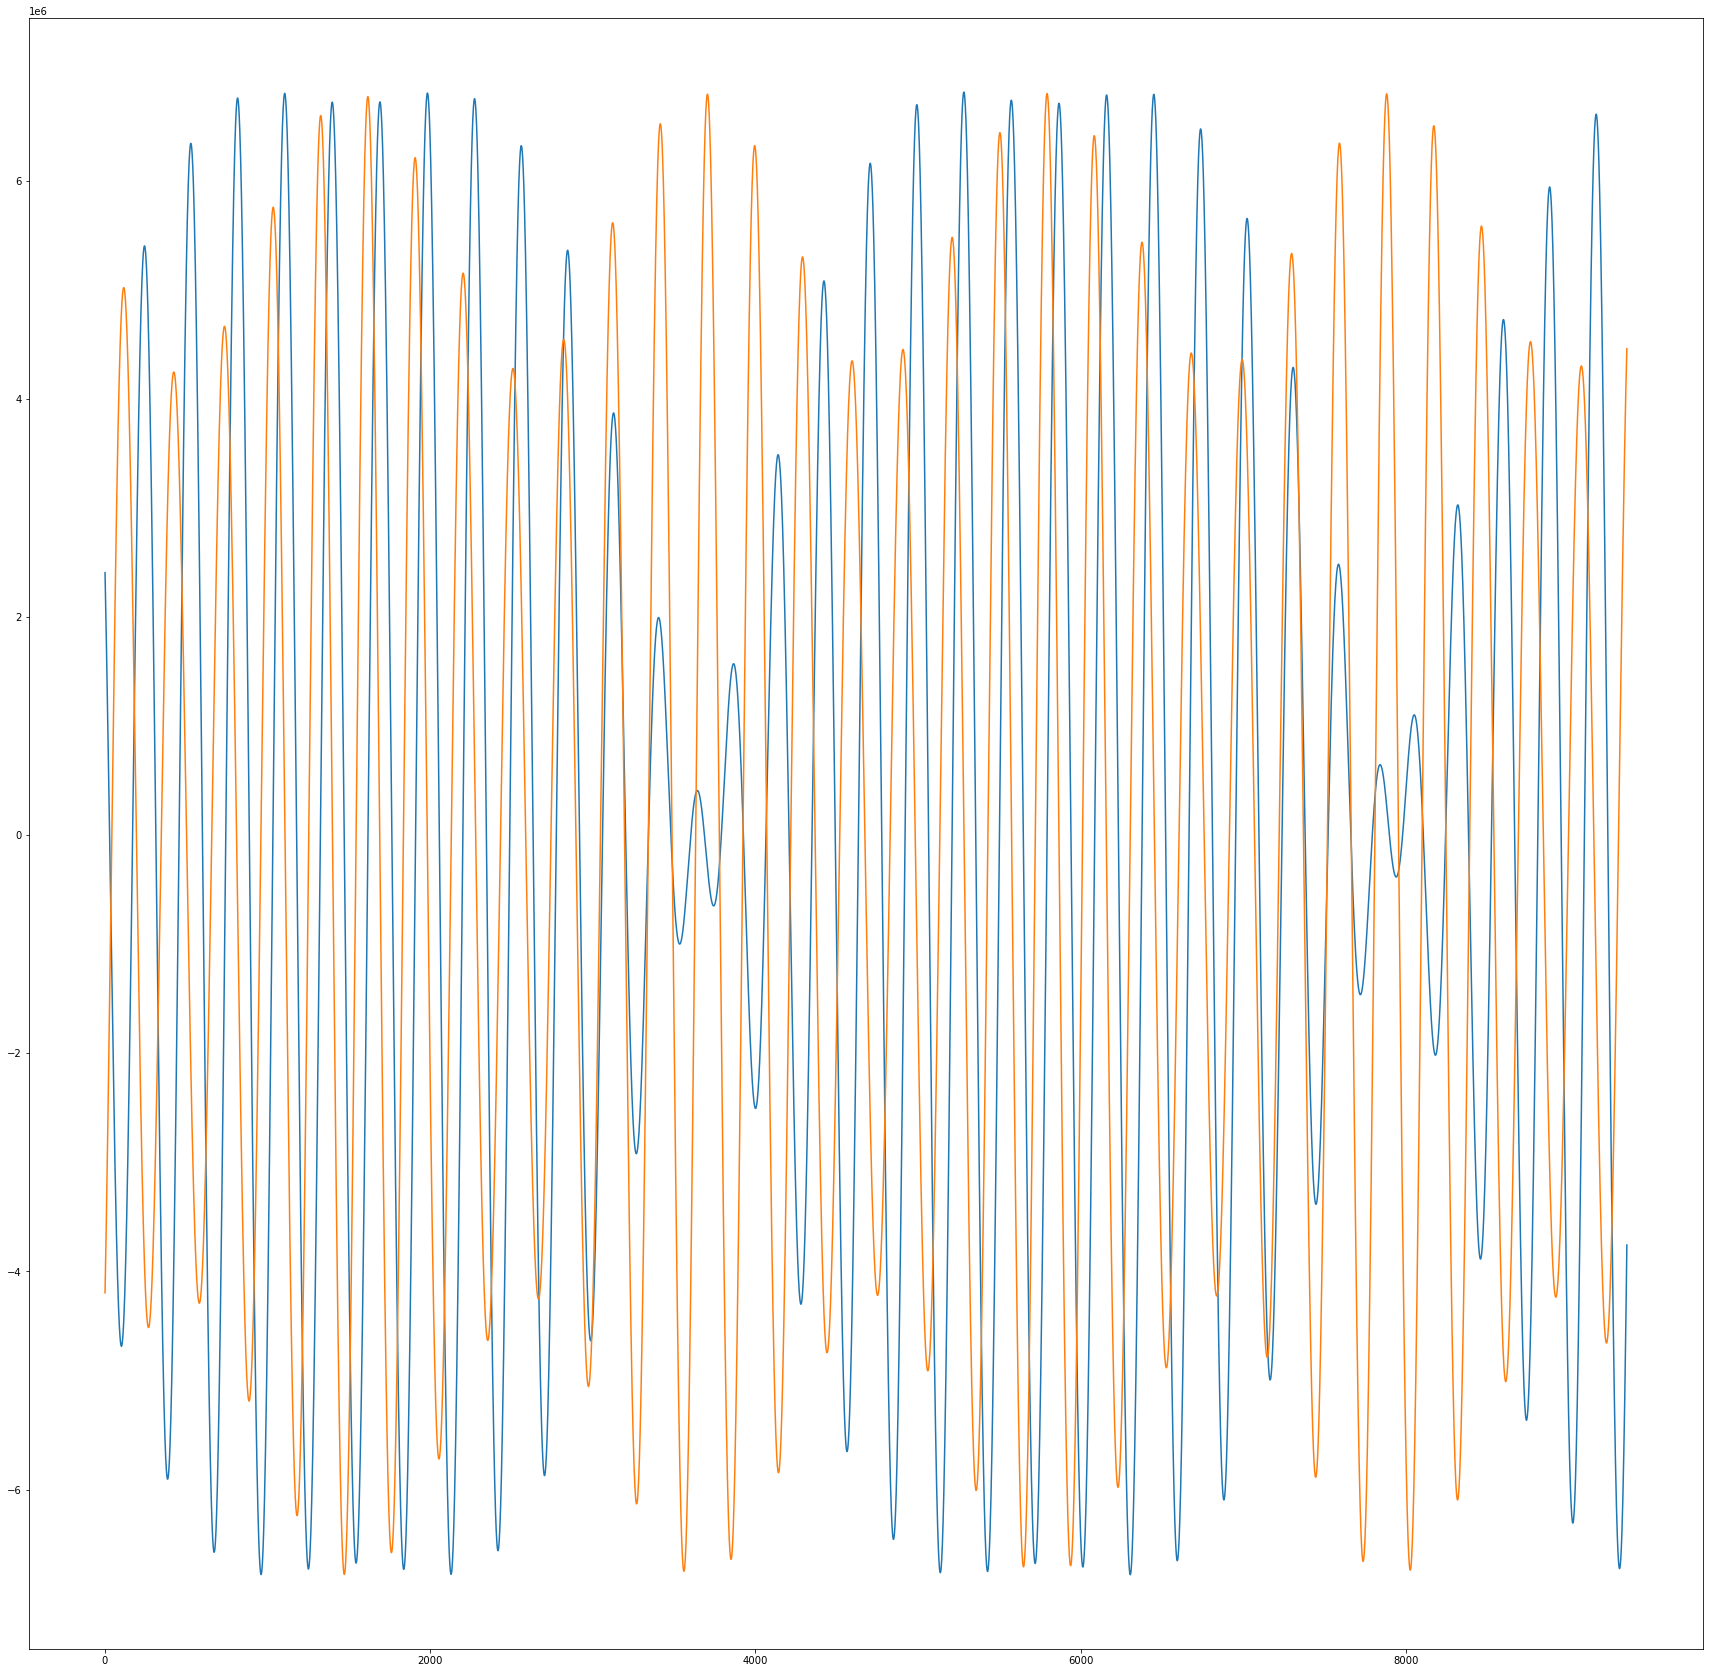

In [133]:
plt.plot(Y)
plt.plot(X)

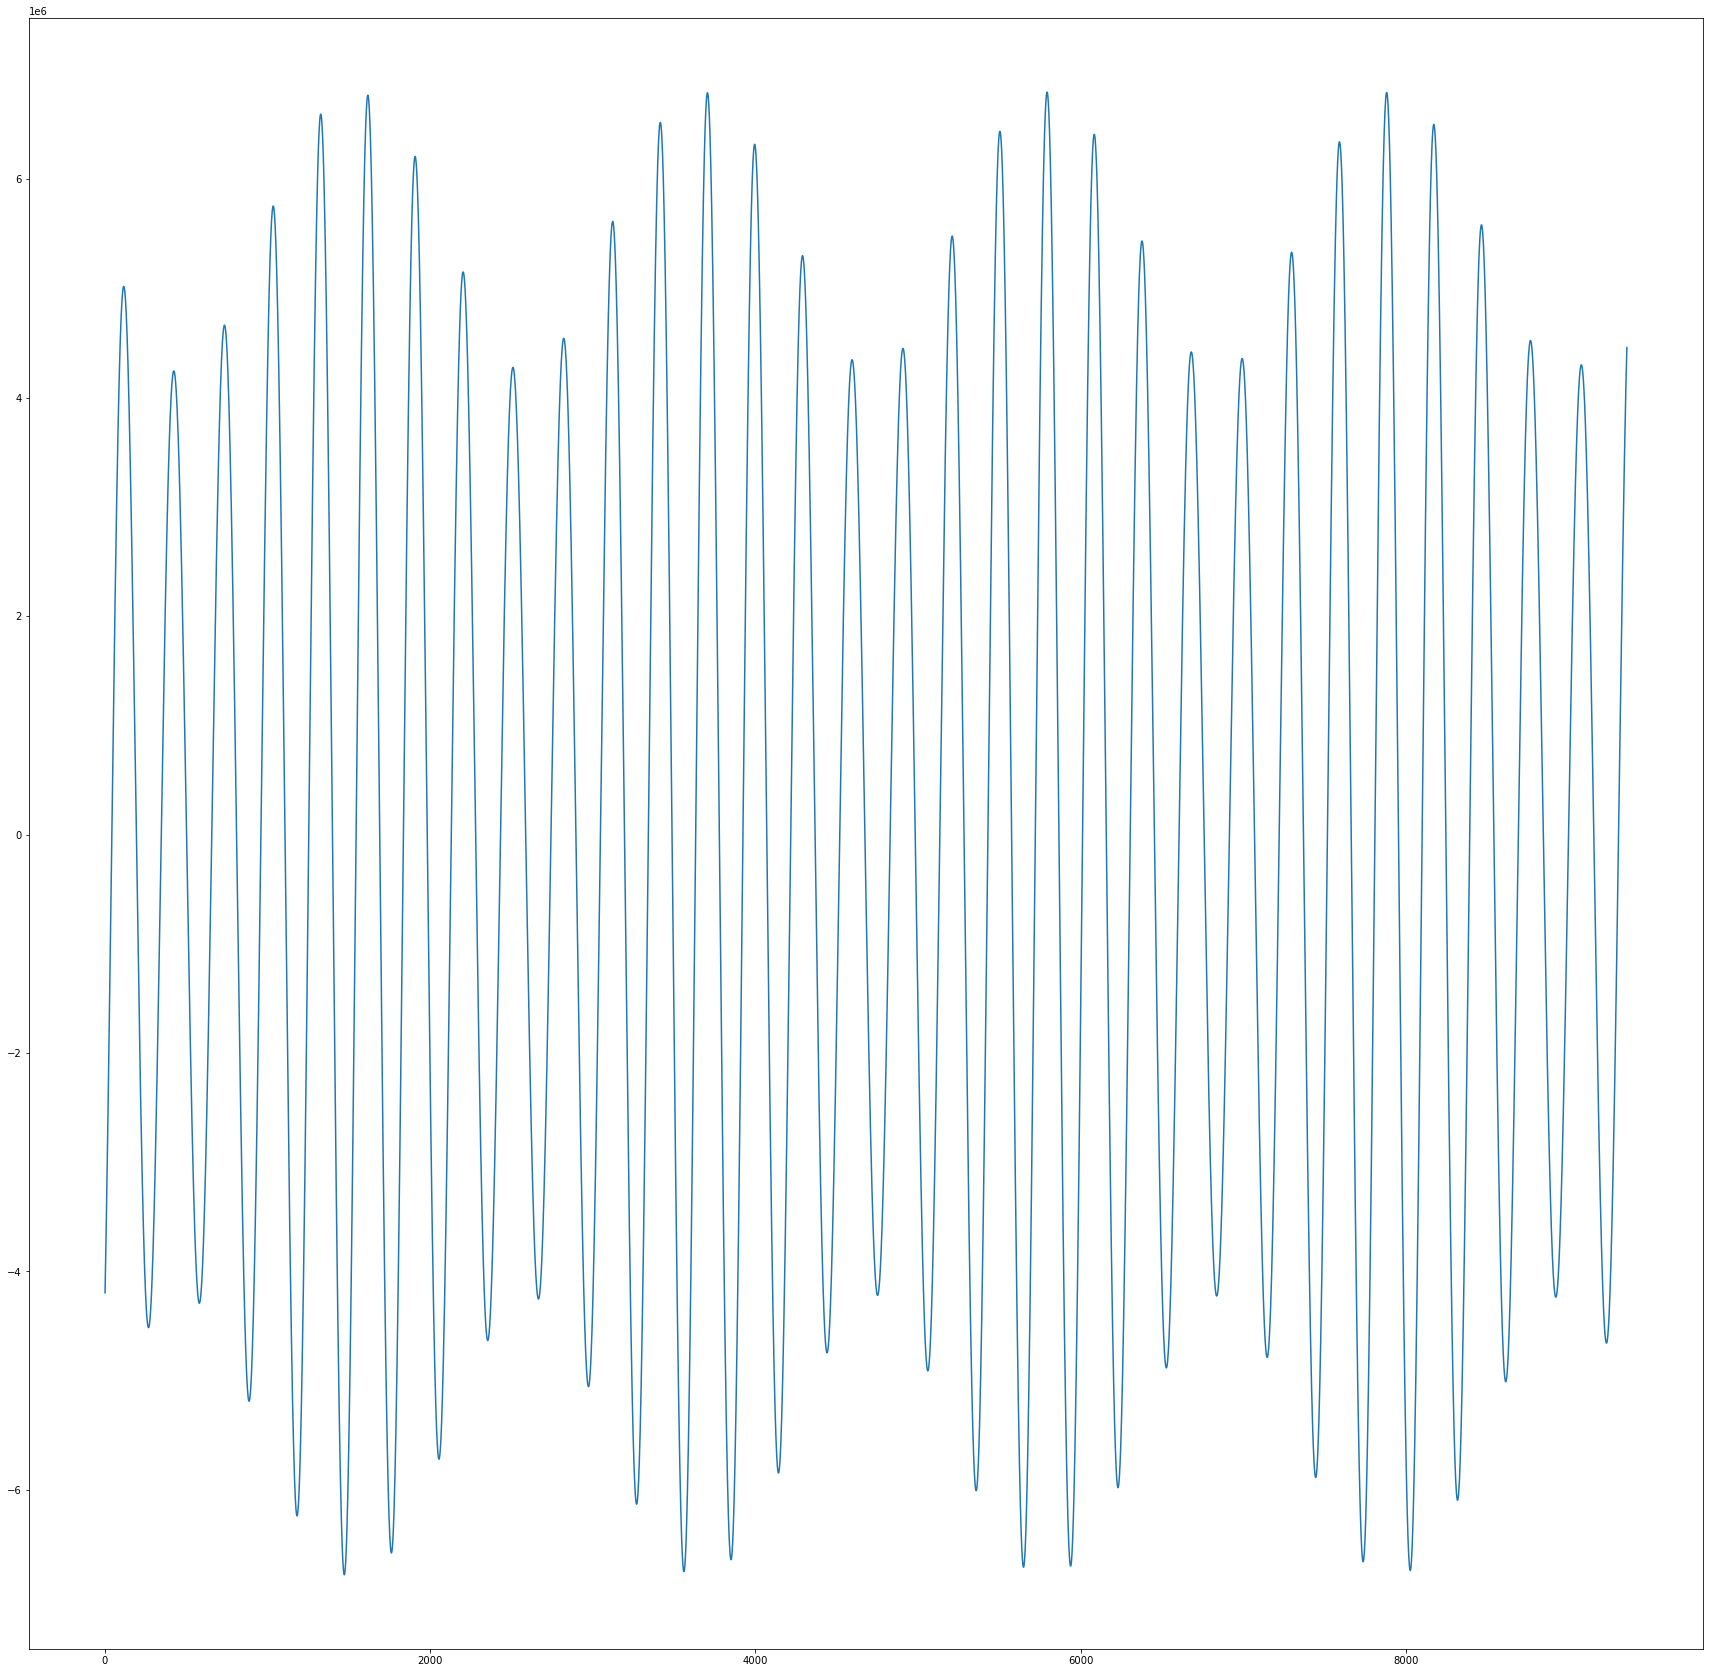

In [134]:
plt.plot(X)

In [135]:
# print(abs(Y[20]))
# print(abs(Y[29]))
# print(abs(Y[2489]))
# print(Y[2489])

print(X[1399])


-46689.53351604555


In [136]:
originInITRF = earth.transform(loloFrame.getPoint())
print(originInITRF)
ITRF.getTransformTo(stationFrame, extrapDate).transformVector(originInITRF)

{6,378,137; 0; 0}


<Vector3D: {-860,097.7078632535; -4,739,151.599883658; 4,181,065.1318793828}>

In [137]:
origin = Vector3D(654.0, 0.6450, 0.0243)
ITRF.getTransformTo(stationFrame, extrapDate).transformVector(earth.transform(stationFrame.getPoint()))

<Vector3D: {0.0000000005; -21,222.3394426688; 6,366,262.797121506}>

In [138]:
earth.transform(loloFrame.getPoint())

<Vector3D: {6,378,137; 0; 0}>

In [139]:
X = X.tolist()
Y = Y.tolist()

In [144]:
print(extrapDate)
print(Date[3342])

2020-08-22T16:50:36.340
2020-08-21T07:24:16.340


In [141]:
stationFrame.getPoint()

<GeodeticPoint: {lat: 48.58 deg, lon: 7.75 deg, alt: 142}>

In [151]:
Date[3342]

<AbsoluteDate: 2020-08-21T07:24:16.340>